# Introduction: Machine Learning Project Part 1

In this notebook, we will walk through solving a complete machine learning problem using a real-world dataset. This was a "homework" assignment given to me for a job application over summer 2018. The entire assignment can be viewed [here](https://github.com/WillKoehrsen/machine-learning-project/blob/master/hw_assignment.pdf) and the one sentence summary is:

__Use the provided building energy data to develop a model that can predict a building's Energy Star score, and then interpret the results to find the variables that are most predictive of the score.__

这是一个受监督的回归机器学习任务：给定一组包含目标（在本例中为分数）的数据，我们希望训练一个可以学习将特征（也称为解释变量）映射到目标的模型。
* Supervised problem: 我们可以知道数据的特征和目标，我们的目标是训练可以学习两者之间映射关系的模型。
* Regression problem: Energy Star Score是一个连续变量。

During training, we want the model to learn the relationship between the features and the score so we give it both the features and the answer. Then, to test how well the model has learned, we evaluate it on a testing set where it has never seen the answers! 

## Machine Learning Workflow

虽然确切的实现细节可能有所不同，但机器学习项目的一般结构保持相对稳定：

1. 数据清理和格式化

2. 探索性数据分析

3. 特征工程和特征选择

4. 在性能指标上比较几种机器学习模型

5. 对最佳模型执行超参数调整

6. 在测试集合中评估最佳模型

7. 解释模型结果

8. 得出结论


提前设置管道结构让我们看到一步流入另一步。但是，机器学习管道是一个迭代过程，因此我们并不总是以线性方式遵循这些步骤。我们可能会根据管道下游的结果重新审视上一步。例如，虽然我们可以在构建任何模型之前执行特征选择，但我们可以使用建模结果返回并选择一组不同的特征。 或者，建模可能会出现意想不到的结果，这意味着我们希望从另一个角度探索我们的数据。 一般来说，你必须完成一步才能继续下一步，但不要觉得一旦你第一次完成一步，你就不能回头做出改进！


这个笔记将涵盖管道的前三个（半个）步骤，其他部分将在另外两个笔记本中讨论。 在本系列文章中，目标是展示所有不同的数据科学实践如何组合在一起形成一个完整的项目。 我尝试更多地关注方法的实现，而不是在低级别解释它们，但为那些想要更深入的人提供了资源。

For the single best book (in my opinion) for learning the basics and implementing machine learning practices in Python, check out [Hands-On Machine Learning with Scikit-Learn and Tensorflow](http://shop.oreilly.com/product/0636920052289.do) by [Aurelion Geron](https://twitter.com/aureliengeron?lang=en). 

With this outline in place to guide us, let's get started! 

## Imports
 
We will use the standard data science and machine learning libraries: `numpy`, `pandas`, and `scikit-learn`. We also use `matplotlib` and `seaborn` for visualization. 

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
#不显示关于在切片副本上设置值的警告
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
# 最多显示60列
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
# 可视化工具包
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
#设置默认字体大小
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
# 导入设置图片大小的工具
from IPython.core.pylabtools import figsize

# Seaborn for visualization
#导入用于可视化的Seaborn 
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
#把数据分为训练集和测试集
from sklearn.model_selection import train_test_split

# 1. Data Cleaning and Formatting-数据清理和格式化

## 1.1 Load in the Data and Examine

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science. Think of it as a spreadsheet within Python that we can easily manipulate, clean, and visualize. [Pandas has many methods](http://pandas.pydata.org/pandas-docs/stable/) to help make the data science/machine learning pipeline as smooth as possible.

In [3]:
# Read in data into a dataframe 
# 把数据读入pandas dataframe
data = pd.read_csv('data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

# Display top of dataframe
# 显示表头
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

在加载完数据后，我们会遇到第一个问题：**理解数据**。我们通常会看到每一列的第一行是各种名词，就是所谓的表头，理解这些名词的含义对于处理数据非常重要，但是我们面对的数据来自各个领域，数据科学家不是精通各个领域专业知识的杂家，这时候就需要通过各种手段去理解数据：

1. 查看数据文件的文件名，寻找线索，在本例中，数据文件名是：
*Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv*
这里面有一个*Local_Law_84*，即地方性84号法规，这时候就可以根据Local_Law_84展开搜索，获得两个资料： [this webpage](http://www.nyc.gov/html/gbee/html/plan/ll84.shtml) 和[this pdf document](http://www.nyc.gov/html/gbee/downloads/misc/nyc_benchmarking_disclosure_data_definitions_2017.pdf)，第二个文件对于数据中的每一个名词给出了详细的定义。也许看一个文件名是一个明显的开始，但对我来说，这是提醒你要放慢速度，这样你才不会错过任何重要的东西！

2. 直接搜索每一列第一行出现的名词，我们不需要研究所有的列的定义，但我们至少应该了解Energy Star Score，它被描述为：
**根据报告年度中，自我报告的能源使用情况而进行的1至100百分位的排名。 Energy Star Score是用于比较建筑物能效的相对度量。**

第二个问题是**缺少的值被编码为“Not Available”**。这是Python中的一个字符串，这意味着甚至包含数字的列都将被存储为object数据类型，因为Pandas会将包含任何字符串的列转换为所有元素都为字符串的列。我们可以使用dataframe.info（）方法来**查看列的数据类型**：

## 1.2 Data Types and Missing Values-数据类型和缺失值

The `dataframe.info` method is a quick way to assess the data by displaying the data types of each column and the number of non-missing values. Already from looking at the dataframe, there might be a problem because the missing values are coded as "Not Available" rather than as `np.nan` (not a number). This means the columns with numbers will not be represented as numeric because pandas converts columns with any strings values into columns of all strings.

In [4]:
# See the column data types and non-missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11746 entries, 0 to 11745
Data columns (total 60 columns):
Order                                                         11746 non-null int64
Property Id                                                   11746 non-null int64
Property Name                                                 11746 non-null object
Parent Property Id                                            11746 non-null object
Parent Property Name                                          11746 non-null object
BBL - 10 digits                                               11735 non-null object
NYC Borough, Block and Lot (BBL) self-reported                11746 non-null object
NYC Building Identification Number (BIN)                      11746 non-null object
Address 1 (self-reported)                                     11746 non-null object
Address 2                                                     11746 non-null object
Postal Code                                          

一些明确包含数字（例如ft²）的列被存储为object类型。 我们不能对字符串进行数值分析，因此必须将其转换为数字（特别是浮点数）数据类型！

### 1.2.1Convert Data to Correct Types


我们将带有数字的列转换为数字数据类型，方法是将“Not Available”条目替换为可以解释为浮点数的np.nan。 然后我们将包含数值（例如平方英尺或能量使用）的列转换为float数据类型:

In [5]:
# Replace all occurrences of Not Available with numpy not a number
#将“Not Available”条目替换为可以解释为浮点数的np.nan
data = data.replace({'Not Available': np.nan})

#一些明确包含数字（例如ft²）的列被存储为object类型。 我们不能对字符串进行数值分析，因此必须将其转换为数字（特别是浮点数）数据类型
# Iterate through the columns
#对列数进行迭代
for col in list(data.columns):
    # Select columns that should be numeric，选择需要被数字化的列，通过if 判断实现
    # 凡是包含下列红色字体的列，都需要被转化为数据类型
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

In [6]:
# Statistics for each column
data.describe()

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Latitude,Longitude,Community Board,Council District,Census Tract
count,11746.000000,1.174600e+04,1.162800e+04,1.174400e+04,3741.000000,1484.000000,11746.000000,11746.000000,11746.000000,9642.000000,11583.000000,10281.000000,10959.000000,9783.000000,10281.000000,9.000000e+00,2.581000e+03,1.321000e+03,5.940000e+02,1.600000e+01,9.360000e+02,1.030400e+04,9.784000e+03,1.150200e+04,1.096000e+04,1.167200e+04,1.166300e+04,1.168100e+04,1.174600e+04,7.762000e+03,7762.000000,11583.000000,9483.000000,9483.000000,9483.000000,9483.000000,9483.000000
mean,7185.759578,3.642958e+06,1.732695e+05,1.605524e+05,22778.682010,12016.825270,1948.738379,1.289971,98.762557,59.854594,280.071484,309.747466,11.072643,1.901441,417.915709,3.395398e+06,3.186882e+06,5.294367e+06,2.429105e+06,1.193594e+06,2.868907e+08,5.048545e+07,5.364578e+05,5.965472e+06,1.768752e+06,4.553657e+03,2.477937e+03,2.076339e+03,1.673739e+05,1.591798e+04,136.172432,385.908029,40.754379,-73.957057,7.140673,15.771275,4977.596647
std,4323.859984,1.049070e+06,3.367055e+05,3.095746e+05,55094.441422,27959.755486,30.576386,4.017484,7.501603,29.993586,8607.178877,9784.731207,127.733868,97.204587,10530.524339,2.213237e+06,5.497154e+06,5.881863e+06,4.442946e+06,3.558178e+06,3.124603e+09,3.914719e+09,4.022606e+07,3.154430e+07,9.389154e+06,2.041639e+05,1.954498e+05,5.931295e+04,3.189238e+05,1.529524e+05,1730.726938,9312.736225,0.080120,0.046337,3.954129,15.674375,13520.422990
min,1.000000,7.365000e+03,5.002800e+04,5.400000e+01,0.000000,0.000000,1600.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.085973e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.690797e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.313430e+04,0.000000e+00,0.000000e+00,0.000000,0.000000,40.516065,-74.243582,1.000000,1.000000,1.000000
25%,3428.250000,2.747222e+06,6.524000e+04,6.520100e+04,4000.000000,1720.750000,1927.000000,1.000000,100.000000,37.000000,61.800000,65.100000,3.800000,0.100000,103.500000,1.663594e+06,2.550378e+05,2.128213e+06,0.000000e+00,5.698020e+04,4.320254e+06,1.098251e+06,1.176952e+04,1.043673e+06,3.019974e+05,3.287000e+02,1.474500e+02,9.480000e+01,6.699400e+04,2.595400e+03,27.150000,99.400000,40.707226,-73.984662,4.000000,4.000000,100.000000
50%,6986.500000,3.236404e+06,9.313850e+04,9.132400e+04,8654.000000,5000.000000,1941.000000,1.000000,100.000000,65.000000,78.500000,82.500000,5.300000,0.500000,129.400000,4.328815e+06,1.380138e+06,4.312984e+06,0.000000e+00,2.070020e+05,9.931240e+06,4.103962e+06,4.445525e+04,1.855196e+06,5.416312e+05,5.002500e+02,2.726000e+02,1.718000e+02,9.408000e+04,4.692500e+03,45.095000,124.900000,40.759130,-73.962810,7.000000,9.000000,201.000000
75%,11054.500000,4.409092e+06,1.596140e+05,1.532550e+05,20000.000000,12000.000000,1966.000000,1.000000,100.000000,85.000000,97.600000,102.500000,9.200000,0.700000,167.200000,4.938947e+06,4.445808e+06,6.514520e+06,4.293825e+06,2.918332e+0

## 1.3 Missing Values-缺失值



现在我们有了正确的列数据类型，我们可以通过查看每列中缺失值的百分比来开始分析。 当我们进行探索性数据分析时，缺失的值很好，但是必须使用机器学习方法填写。

以下是一个函数，用于计算缺失值的数量以及每列缺少的总值的百分比。 与数据科学中的许多任务一样，我自己并没有编写这个函数，而是在[Stack Overflow forum](https://stackoverflow.com/a/39734251)! 在线论坛中发现它！

In [7]:
# Function to calculate missing values by column
#计算每一列中缺失值的比例
def missing_values_table(df):
        # Total missing values
        #计算总的缺失值
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        #计算缺失值的百分比
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        #把结果制成表格
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        #对列重命名，第一列：Missing Values，第二列：% of Total Values
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        #根据百分比对表格进行降序排列
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        #打印总结信息：总的列数，有数据缺失的列数
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        # 返回带有缺失值信息的dataframe
        return mis_val_table_ren_columns

In [8]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


处理真实世界数据时的另一个常见问题是缺失值。 这可能是由于许多原因引起的，在我们训练机器学习模型之前必须填写或删除。首先，让我们了解每列中有多少缺失值。如果列中缺失值的比例很高，那么它对我们的模型可能不会有用。删除列的阈值应该取决于实际问题，并且对于此项目，我们将删除缺失值超过50％的列。 

In [9]:
# Get the columns with > 50% missing
# 获取缺失值超过50％的列
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [10]:
# Drop the columns
#删除缺失值超过50％的列
#data = data.drop(columns = list(missing_columns))

# For older versions of pandas (https://github.com/pandas-dev/pandas/issues/19078)
# 旧版本的pandas 使用如下代码
data = data.drop(list(missing_columns), axis = 1)

The rest of the missing values will have to be imputed (filled-in) using an appropriate strategy before doing machine learning. 

# 2. Exploratory Data Analysis-探索性数据分析

[Exploratory Data Analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis) is an open-ended process where we make plots and calculate statistics in order to explore our data. The purpose is to to find anomalies, patterns, trends, or relationships. These may be interesting by themselves (for example finding a correlation between two variables) or they can be used to inform modeling decisions such as which features to use. In short, the goal of EDA is to determine what our data can tell us! EDA generally starts out with a high-level overview, and then narrows in to specific parts of the dataset once as we find interesting areas to examine. 

To begin the EDA, we will focus on a single variable, the Energy Star Score, because this is the target for our machine learning models. We can rename the column to `score` for simplicity and then start exploring this value.

探索性数据分析（EDA）是一个开放式流程，我们制作绘图并计算统计数据，以便探索我们的数据。 目的是找到异常，模式，趋势或关系。 这些可能是有趣的（例如，找到两个变量之间的相关性），或者它们可用于通知建模决策，例如使用哪些特征。 简而言之，EDA的目标是确定我们的数据可以告诉我们什么！ EDA通常以高级概述(high-level overview)开始，然后在我们找到要检查的有趣区域时缩小到数据集的特定部分。

要开始EDA，我们将专注于单一变量，the Energy Star Score，因为这是我们的机器学习模型的目标。 为简单起见，我们可以将列重命名为得分，然后开始探索此值。

## 2.1 Single Variable Plots- 单变量图

A single variable (called [univariate](https://en.wikipedia.org/wiki/Univariate_(statistics)) plot shows the distribution of a single variable such as in a histogram.
单个变量（称为[单变量]（https://en.wikipedia.org/wiki/Univariate_（统计））图表显示单个变量的分布，例如直方图。                   

目标是预测Energy Star Score（将其重新命名为score），因此合理的开始是检查此变量的分布。直方图是可视化单个变量分布的简单而有效的方法，使用matplotlib很容易。

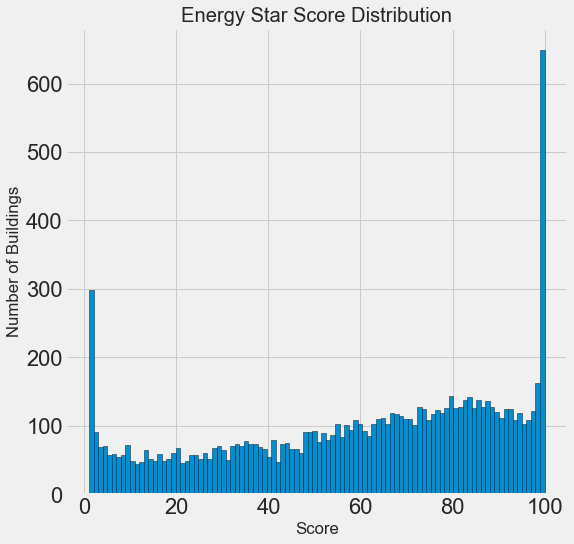

In [11]:
#设置图形尺寸为 8cm x 8cm
figsize(8, 8)

# Rename the score
# 将Energy Star Score重新命名为score
data = data.rename(columns = {'ENERGY STAR Score': 'score'})

# Histogram of the Energy Star Score
#绘制直方图
plt.style.use('fivethirtyeight')
plt.hist(data['score'].dropna(), bins = 100, edgecolor = 'k');
# x,y 坐标轴标签
plt.xlabel('Score'); plt.ylabel('Number of Buildings'); 
#图标名称
plt.title('Energy Star Score Distribution');

我们的第一个情节已经揭示了一些令人惊讶（和可疑）的信息！由于能源之星得分是百分位数，我们预计会看到完全平坦的分布，每个得分占分布的1％（约90个建筑物）。然而，事实并非如此，因为我们可以看到两个最常见的分数1和100构成总分数的不相称的数字。

如果我们回到分数的定义，我们会看到它基于自我报告的能量使用情况。这造成了一个问题，因为建筑物所有者可能想要报告较低的用电量以人为地提高他们的建筑物的分数。这就像求学生在测试中报告自己的分数。这种行为可以解释高比例的建筑物满分为100，但不能解释为什么这么多建筑物在最底层得分！

为了对比能源之星得分，我们可以看一下**能源使用强度（EUI）**，它是总能源消耗除以建筑物的平方英尺。这里的能源使用量不是自我报告的，因此这可以更客观地衡量建筑物的能源效率。此外，这不是百分位数，因此绝对值很重要，我们希望它们近似正态分布，可能在低端或高端有一些异常值。

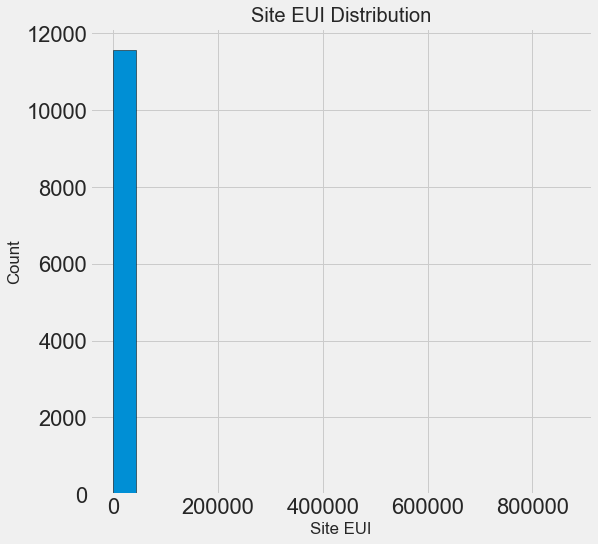

In [12]:
# Histogram Plot of Site EUI
# 绘制 能源使用强度（EUI）的直方图
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

这表明我们还有另一个问题：异常值！ 由于存在一些分数非常高的建筑物，因此图表非常倾斜。 看起来我们将不得不稍微绕道来处理异常值。 我们来看看这个功能的统计数据。

In [13]:
data['Site EUI (kBtu/ft²)'].describe()

count     11583.000000
mean        280.071484
std        8607.178877
min           0.000000
25%          61.800000
50%          78.500000
75%          97.600000
max      869265.000000
Name: Site EUI (kBtu/ft²), dtype: float64

In [14]:
# 取出前10名来
data['Site EUI (kBtu/ft²)'].dropna().sort_values().tail(10)

3173     51328.8
3170     51831.2
3383     78360.1
8269     84969.6
3263     95560.2
8268    103562.7
8174    112173.6
3898    126307.4
7       143974.4
8068    869265.0
Name: Site EUI (kBtu/ft²), dtype: float64

Wow! One building is clearly far above the rest.其中一栋建筑远远高于其他建筑。

In [15]:
#定位能源使用强度（EUI）最高的建筑，查看详情
data.loc[data['Site EUI (kBtu/ft²)'] == 869265, :]

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
8068,9984,4414323,234 Skillman,Not Applicable: Standalone Property,Not Applicable: Standalone Property,3028937502,3028937502,"3390250 , 3338313",234 Skillman avenue,11211,234,SKILLMAN AVENUE,Brooklyn,61811.0,Multifamily Housing,Multifamily Housing,Multifamily Housing,56900.0,2004,1,90,Whole Building,NaN,1.0,869265.0,939329.0,9.9,9393.0,986366.0,4.945919e+10,534458968.8,1983655.6,563239.6,2627199.1,2627015.0,184.1,56900.0,2547.9,44.78,912801.1,05/01/2017 11:34:14 PM,NaN,In Compliance,40.716233,-73.94141,1.0,34.0,477.0,East Williamsburg ...


有人跟进这个建筑物的所有者可能是值得的！ 但是，这不是我们的问题，我们只需要弄清楚如何处理这些信息。 **异常值可能由于多种原因而发生**：
- 打字错误
- 测量设备故障
- 不正确的单位
- 或者它们可能是合法的但是极端值。 

异常值可以抛弃，因为它们并不表示数据的实际分布。

It might be worthwhile for someone to follow up with this building owner! However, that is not our problem and we only need to figure out how to handle this information. [Outliers](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) can occur for many reasons: typos, malfunctions in measuring devices, incorrect units, or they can be legitimate but extreme values. Outliers can throw off a model because they are not indicative of the actual distribution of data. 

### 2.2. Removing Outliers- 去除异常值

When we remove outliers, we want to be careful that we are not throwing away measurements just because they look strange. They may be the result of actual phenomenon that we should further investigate. When removing outliers, I try to be as conservative as possible, using the definition of an [extreme outlier](https://people.richland.edu/james/lecture/m170/ch03-pos.html): 

* On the low end, an extreme outlier is below  $\text{First Quartile} -3 * \text{Interquartile Range}$
* On the high end, an extreme outlier is above $\text{Third Quartile} + 3 * \text{Interquartile Range}$



当我们删除异常值时，我们要小心，因为它们看起来很奇怪，我们不会丢弃测量值。 它们可能是我们应该进一步研究的实际现象的结果。 当删除异常值时，我尝试使用极端异常值的定义尽可能保守：

* 在低端，极端异常值低于 $\text{First Quartile} -3 * \text{Interquartile Range}$
* 在高端，极端异常值高于 $\text{Third Quartile} + 3 * \text{Interquartile Range}$

在这种情况下，我将只删除单个外围点并查看分布的外观。

In [16]:
# Calculate first and third quartile
# 计算第一和第三 四分数
first_quartile = data['Site EUI (kBtu/ft²)'].describe()['25%']
third_quartile = data['Site EUI (kBtu/ft²)'].describe()['75%']

# Interquartile range
# 四分位数范围
iqr = third_quartile - first_quartile

# Remove outliers
# 去除异常值
data = data[(data['Site EUI (kBtu/ft²)'] > (first_quartile - 3 * iqr)) &
            (data['Site EUI (kBtu/ft²)'] < (third_quartile + 3 * iqr))]

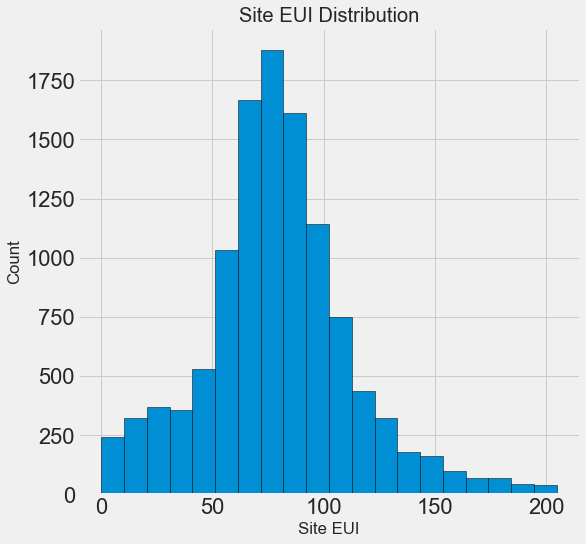

In [17]:
# Histogram Plot of Site EUI
figsize(8, 8)
plt.hist(data['Site EUI (kBtu/ft²)'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('Site EUI'); 
plt.ylabel('Count'); plt.title('Site EUI Distribution');

After removing the outliers, we can get back to the analysis.

虽然这可能是一个更客观的衡量标准，但我们的目标仍然是预测能源之星得分，因此我们将回过头来研究这个变量。 即使分数不是一个好的衡量标准，我们仍然需要预测它，这就是我们将要做的事情！ 在回到公司的最终报告中，我将指出这可能不是一个客观的衡量标准，并且使用不同的指标来确定建筑物的效率是个好主意。 此外，如果我们有更多时间参与这个项目，那么看看分数为1和100的建筑物可能会很有趣，看看它们是否有任何共同之处。

This plot looks a little less suspicious and is close to normally distributed with a long tail on the right side (it has a positive skew). 


## 2.3. Looking for Relationships- 寻找关系

In order to look at the effect of **categorical variables** on the score, we can make a [density plot](https://datavizcatalogue.com/methods/density_plot.html) colored by the value of the categorical variable. Density plots also show the distribution of a single variable and can be thought of as a smoothed histogram. 
If we color the density curves by a **categorical variable**, this will shows us how the distribution changes based on the class. 



为了查看**类别属性**对分数的影响，我们可以通过**类别属性**的值来绘制**密度图**。 密度图还显示单个变量的分布，可以认为是平滑的直方图。 如果我们通过**类别属性**为密度曲线着色，这将向我们展示分布如何根据类进行更改。

我们将制作的第一个图表显示了**类别属性**的分数分布。 为了不使图形混乱，我们将图形限制为在数据集中具有超过100个观测值的建筑类型。

In [18]:
# Create a list of buildings with more than 100 measurements
# 创建一个包含100多个测量值的建筑物列表
types = data.dropna(subset=['score'])
types = types['Largest Property Use Type'].value_counts()
types = list(types[types.values > 100].index)

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


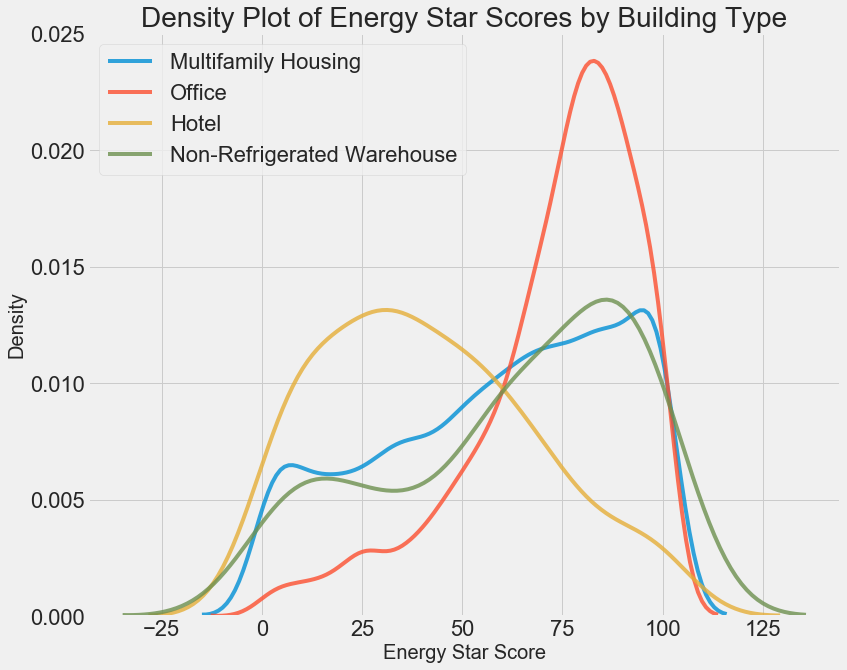

In [19]:
# Plot of distribution of scores for building categories
figsize(12, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = data[data['Largest Property Use Type'] == b_type]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Building Type', size = 28);

我们可以看到建筑类型对Energy Star Score有重大影响。 办公楼往往有较高的分数，而酒店的分数较低。这告诉我们，我们应该在建模中包含建筑类型，因为它确实对目标有影响。 作为**类别属性**，我们将不得不对建筑物类型进行one-hot编码。

From this graph, we can see that the building type does have an effect on the score (the negative scores on the graph are an artifact of the [kernel density estimation](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) procedure).  While I was initially going to focus on the numerical columns for predicting the score, this graph tells us that we should include the property type because this information can be useful for determining the score. As building type is a categorical variable, it will have to be one-hot encoded before we can feed it into a machine learning model. 

To examine another categorical variable, borough, we can make the same graph, but this time colored by the borough.

显示自治市镇的Energy Star Score

In [20]:
# Create a list of boroughs with more than 100 observations
boroughs = data.dropna(subset=['score'])
boroughs = boroughs['Borough'].value_counts()
boroughs = list(boroughs[boroughs.values > 100].index)

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


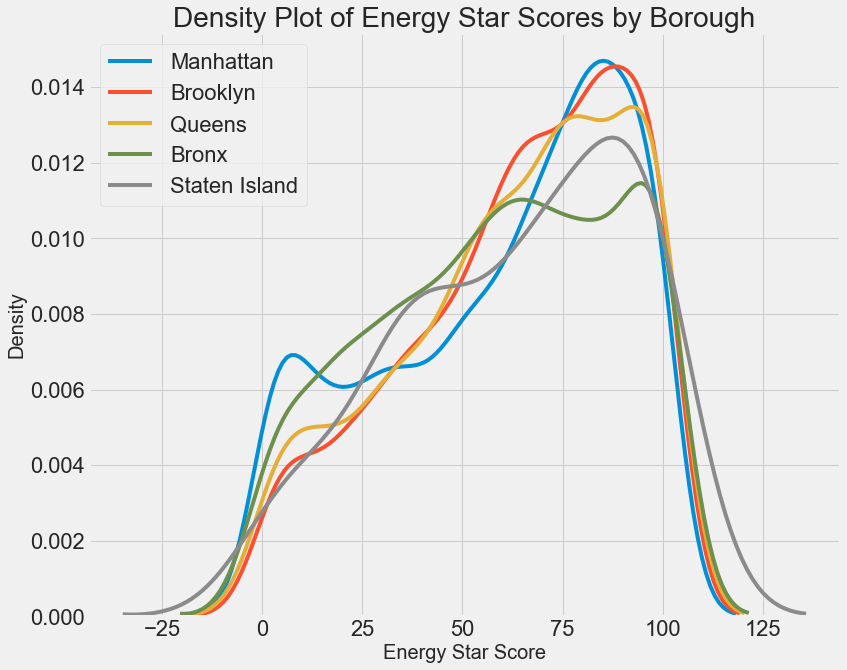

In [21]:
# Plot of distribution of scores for boroughs
figsize(12, 10)

# Plot each borough distribution of scores
for borough in boroughs:
    # Select the building type
    subset = data[data['Borough'] == borough]
    
    # Density plot of Energy Star scores
    sns.kdeplot(subset['score'].dropna(),
               label = borough);
    
# label the plot
plt.xlabel('Energy Star Score', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Energy Star Scores by Borough', size = 28);

The borough of the building does not seem to make as significant a difference in the distribution of the score as does the building type. Nonetheless, it might make sense to include the borough as a categorical variable. 

自治市镇对建筑类型的评分似乎没有太大的影响。 尽管如此，我们可能希望将其纳入我们的模型中，因为各区之间存在细微的差异。

## 2.4. Correlations between Features and Target- 特征与目标之间的相关性

In order to quantify correlations between the features (variables) and the target, we can calculate the [Pearson correlation coefficient](http://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/). This is a measure of the strength and direction of a linear relationship between two variables: a value of -1 means the two variables are perfectly negatively linearly correlated and a value of +1 means the two variables are perfectly positively linearly correlated. The figure below shows different values of the correlation coeffient and how they appear graphically.

![](images/correlation_examples.png)

Although there can be non-linear relationships between the features and targets and correlation coefficients do not account for interactions between features, linear relationships are a good way to start exploring trends in the data. We can then use these values for selecting the features to employ in our model.

The code below calculates the correlation coefficients between all the variables and the score.

![image.png](https://upload-images.jianshu.io/upload_images/12990158-51164c4a360c6472.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

为了量化**特征**（变量）和**目标**之间的相关性，我们可以计算**Pearson相关系数**。 这是两个变量之间线性关系的强度和方向的度量：值-1表示两个变量完全负线性相关，值+1表示两个变量完全正线性相关。 上图显示了相关系数的不同值以及它们如何以图形方式显示。

尽管特征和目标之间可能存在非线性关系，并且相关系数不考虑特征之间的相互作用，但**线性关系**是开始探索数据趋势的好方法。 然后，我们可以使用这些值来选择要在我们的模型中使用的特征。

下面的代码计算所有变量和分数之间的相关系数。

In [22]:
# Find all correlations and sort 
correlations_data = data.corr()['score'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

Site EUI (kBtu/ft²)                                          -0.723864
Weather Normalized Site EUI (kBtu/ft²)                       -0.713993
Weather Normalized Source EUI (kBtu/ft²)                     -0.645542
Source EUI (kBtu/ft²)                                        -0.641037
Weather Normalized Site Electricity Intensity (kWh/ft²)      -0.358394
Weather Normalized Site Natural Gas Intensity (therms/ft²)   -0.346046
Direct GHG Emissions (Metric Tons CO2e)                      -0.147792
Weather Normalized Site Natural Gas Use (therms)             -0.135211
Natural Gas Use (kBtu)                                       -0.133648
Year Built                                                   -0.121249
Total GHG Emissions (Metric Tons CO2e)                       -0.113136
Electricity Use - Grid Purchase (kBtu)                       -0.050639
Weather Normalized Site Electricity (kWh)                    -0.048207
Latitude                                                     -0.048196
Proper

特征和目标之间存在几个强烈的负相关。与得分最负相关的是能源使用强度（EUI），场地EUI（kBtu /ft²）和天气归一化场地EUI（kBtu /ft²）的不同类别（这些在计算方式上略有不同）。 EUI是建筑物使用的能量除以建筑物的平方英尺，用于衡量建筑物的效率，其中得分越低越好。直观地说，这些相关性是有意义的：**随着EUI的增加，能源之星得分趋于下降**。

为了考虑可能的非线性关系，我们可以采用**特征的平方根和自然对数变换**，然后用分数计算相关系数。为了尝试捕捉自治市镇或建筑类型之间的任何可能的关系（记住这些是分类变量）和得分，我们将对这些列进行one-hot编码。

在下面的代码中，我们采用数值变量的**对数和平方根变换**，对两个选定的分类变量（建筑类型和行政区）进行one-hot编码，计算所有要素与得分之间的相关性，并显示前15个最积极的和前15个最负相关。这很多，但有了pandas，每一步都很简单！

In [23]:
# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with square root and log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    # 跳过the Energy Star Score 这一列
    if col == 'score':
        next
    else:
        numeric_subset['sqrt_' + col] = np.sqrt(numeric_subset[col])
        numeric_subset['log_' + col] = np.log(numeric_subset[col])

# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Drop buildings without an energy star score
features = features.dropna(subset = ['score'])

# Find correlations with the score 
correlations = features.corr()['score'].dropna().sort_values()

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


In [24]:
# Display most negative correlations
# 显示最负相关的关系
correlations.head(15)

Site EUI (kBtu/ft²)                                            -0.723864
Weather Normalized Site EUI (kBtu/ft²)                         -0.713993
sqrt_Site EUI (kBtu/ft²)                                       -0.699817
sqrt_Weather Normalized Site EUI (kBtu/ft²)                    -0.689019
sqrt_Weather Normalized Source EUI (kBtu/ft²)                  -0.671044
sqrt_Source EUI (kBtu/ft²)                                     -0.669396
Weather Normalized Source EUI (kBtu/ft²)                       -0.645542
Source EUI (kBtu/ft²)                                          -0.641037
log_Source EUI (kBtu/ft²)                                      -0.622892
log_Weather Normalized Source EUI (kBtu/ft²)                   -0.620329
log_Site EUI (kBtu/ft²)                                        -0.612039
log_Weather Normalized Site EUI (kBtu/ft²)                     -0.601332
log_Weather Normalized Site Electricity Intensity (kWh/ft²)    -0.424246
sqrt_Weather Normalized Site Electricity Intensity 

In [25]:
# Display most positive correlations
# 显示最正相关
correlations.tail(15)

sqrt_Order                                                         0.028662
Borough_Queens                                                     0.029545
Largest Property Use Type_Supermarket/Grocery Store                0.030038
Largest Property Use Type_Residence Hall/Dormitory                 0.035407
Order                                                              0.036827
Largest Property Use Type_Hospital (General Medical & Surgical)    0.048410
Borough_Brooklyn                                                   0.050486
log_Community Board                                                0.055495
Community Board                                                    0.056612
sqrt_Community Board                                               0.058029
sqrt_Council District                                              0.060623
log_Council District                                               0.061101
Council District                                                   0.061639
Largest Prop

After transforming the features, the strongest relationships are still those related to Energy Use Intensity (EUI). The log and square root transformations do not seem the have resulted in any stronger relationships. There are no strong positive linear relationships although we do see that a building type of office (`Largest Property Use Type_Office`) is slightly positively correlated with the score. This variable is a one-hot encoded representation of the categorical variables for building type.

We can use these correlations in order to perform feature selection (coming up in a little bit). Right now, let's graph the most significant correlation (in terms of absolute value) in the dataset which is `Site EUI (kBtu/ft^2)`. We can color the graph by the building type to show how that affects the relationship. 

## 2.5 Two-Variable Plots-  双变量图


In order to visualize the relationship between two variables, we use a scatterplot. We can also include additional variables using aspects such as color of the markers or size of the markers. Here we will plot two numeric variables against one another and use color to represent a third categorical variable.

为了可视化两个变量之间的关系，我们使用散点图。 我们还可以使用诸如标记的颜色或标记的大小等方面包括其他变量。 在这里，我们将相互绘制两个数字变量，并使用颜色表示第三个分类变量。

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


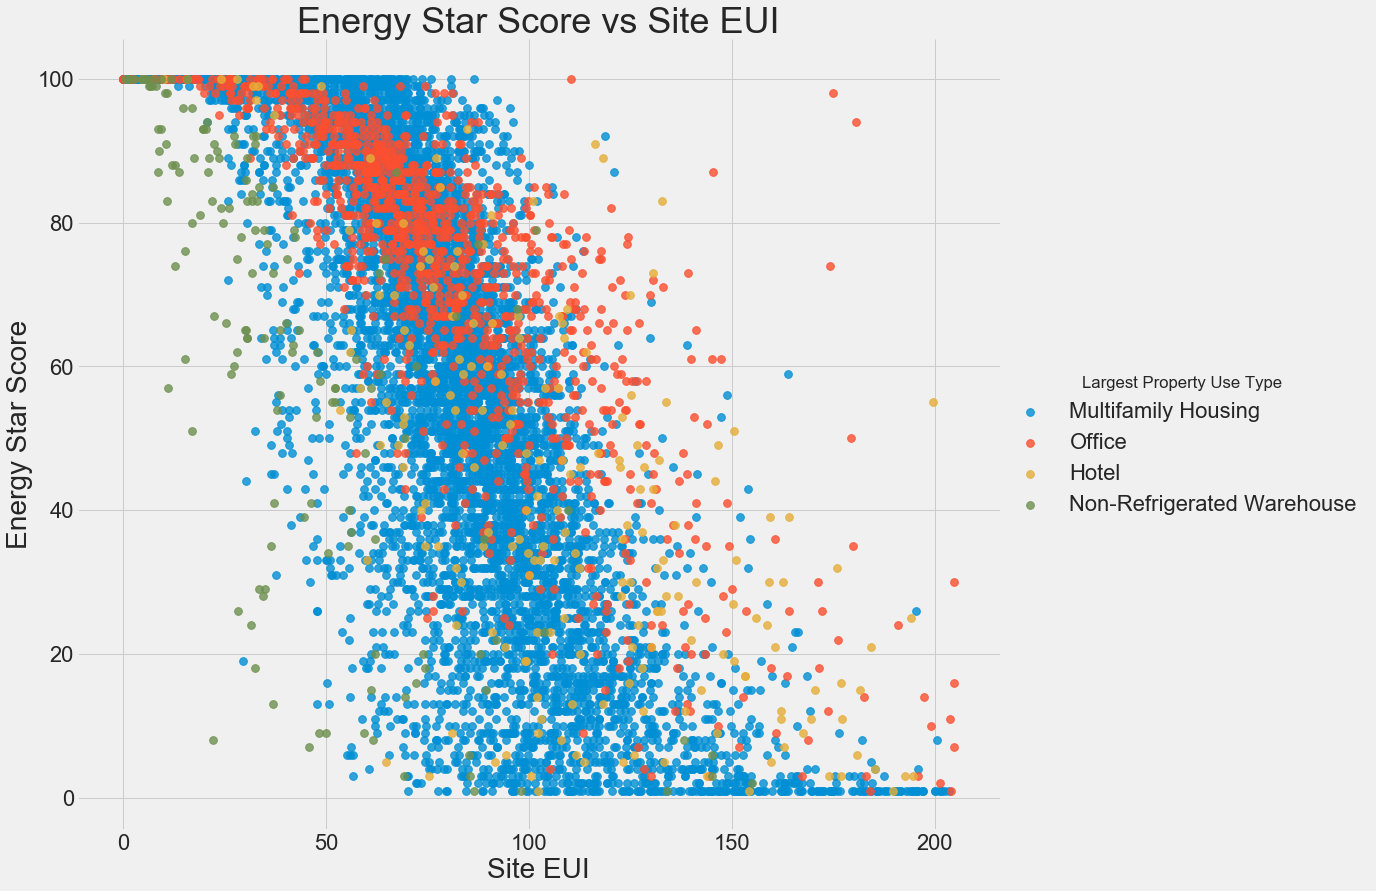

In [26]:
figsize(12, 10)

# Extract the building types
features['Largest Property Use Type'] = data.dropna(subset = ['score'])['Largest Property Use Type']

# Limit to building types with more than 100 observations (from previous code)
features = features[features['Largest Property Use Type'].isin(types)]

# Use seaborn to plot a scatterplot of Score vs Log Source EUI
sns.lmplot('Site EUI (kBtu/ft²)', 'score', 
          hue = 'Largest Property Use Type', data = features,
          scatter_kws = {'alpha': 0.8, 's': 60}, fit_reg = False,
          size = 12, aspect = 1.2);

# Plot labeling
plt.xlabel("Site EUI", size = 28)
plt.ylabel('Energy Star Score', size = 28)
plt.title('Energy Star Score vs Site EUI', size = 36);

Site EUI与得分之间存在明显的负相关关系。 这种关系不是完全线性的（相似系数为-0.7，但看起来这个特征对于预测建筑物的得分非常重要。

### Pairs Plot

As a final exercise for exploratory data analysis, we can make a pairs plot between several different variables. The Pairs Plot is a great way to examine many variables at once as it shows scatterplots between pairs of variables and histograms of single variables on the diagonal. 

Using the seaborn `PairGrid` function, we can map different plots on to the three aspects of the grid. The upper triangle will have scatterplots, the diagonal will show histograms, and the lower triangle will show both the correlation coefficient between two variables and a 2-D kernel density estimate of the two variables. 

作为探索性数据分析的最后一个练习，我们可以在几个不同的变量之间建立一对图。 Pairs Plot是一次检查多个变量的好方法，因为它显示了对角线上变量对和单个变量的直方图之间的散点图。

使用seaborn **PairGrid**函数，我们可以将不同的图绘制到网格的三个方面:
- 上三角形将具有散点图
- 对角线将显示直方图
- 下三角形将显示两个变量之间的相关系数和两个变量的2-D核密度估计。

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


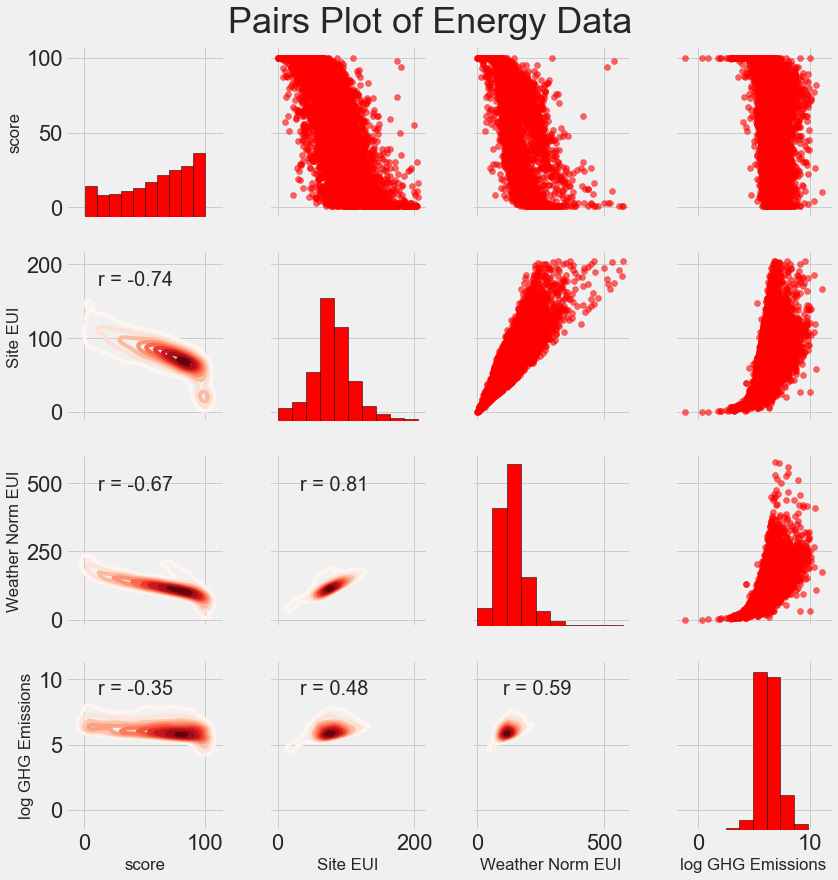

In [27]:
# Extract the columns to  plot
# 提取需要绘图的列
plot_data = features[['score', 'Site EUI (kBtu/ft²)', 
                      'Weather Normalized Source EUI (kBtu/ft²)', 
                      'log_Total GHG Emissions (Metric Tons CO2e)']]

# Replace the inf with nan
plot_data = plot_data.replace({np.inf: np.nan, -np.inf: np.nan})

# Rename columns 
# 重命名
plot_data = plot_data.rename(columns = {'Site EUI (kBtu/ft²)': 'Site EUI', 
                                        'Weather Normalized Source EUI (kBtu/ft²)': 'Weather Norm EUI',
                                        'log_Total GHG Emissions (Metric Tons CO2e)': 'log GHG Emissions'})

# Drop na values
plot_data = plot_data.dropna()

# Function to calculate correlation coefficient between two columns
# 计算某两列之间的相关系数
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
# 上三角是散点图
grid.map_upper(plt.scatter, color = 'red', alpha = 0.6)

# Diagonal is a histogram
# 对角线是直方图
grid.map_diag(plt.hist, color = 'red', edgecolor = 'black')

# Bottom is correlation and density plot
# 下三角是相关系数和二维核密度图
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap = plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of Energy Data', size = 36, y = 1.02);

To interpret the relationships in the plot, we can look for where the variables in one row intersect with the variables in one column. For example, to find the relationship between score and the log of GHG Emissions, we look at the score column and find the log GHG Emissions row. At the intersection (the lower left plot) we see that the score has a -0.35 correlation coefficient with this varible. If we look at the upper right plot, we can see a scatterplot of this relationship. 

要查看变量之间的交互，我们查找行与列相交的位置。例如，要查看Weather EUorm EUI与score的相关性，我们查看Weather EUorm EUI行和score列，并查看相关系数为-0.67。 除了看起来很酷之外，诸如这些图可以帮助我们决定在建模中应该包含哪些变量。

# 3. Feature Engineering and Selection-特征工程和选择

现在我们已经探索了数据中的趋势和关系，我们可以为我们的模型设计一组函数。 我们可以使用EDA的结果来构建特征工程。 特别是，我们从EDA学到了以下知识，可以帮助我们进行特征工程/选择：

* 分数分布因建筑类型而异，并且在较小程度上因行政区而异。 虽然我们将关注数字特征，但我们还应该在模型中包含这两个分类特征。
* 对特征进行对数变换不会导致特征与分数之间的线性相关性显着增加


在我们进一步讨论之前，我们应该定义什么特征工程和选择！ 这些定义是非正式的，并且有很多重叠，但我喜欢将它们视为两个独立的过程：

* __[Feature Engineering](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)__:  获取原始数据并提取或创建新特征的过程。这可能意味着需要对变量进行变换，例如自然对数和平方根，或者对分类变量进行one-hot编码，以便它们可以在模型中使用。 一般来说，我认为特征工程是从原始数据创建附加特征。

* __[Feature Selection](https://machinelearningmastery.com/an-introduction-to-feature-selection/)__:  选择数据中最相关的特征的过程。在特征选择中，我们删除特征以帮助模型更好地总结新数据并创建更具可解释性的模型。一般来说，特征选择是减去特征，所以我们只留下那些最重要的特征。[most variance](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html). 


在特征选择中，我们删除了无助于我们的模型学习特征与目标之间关系的特征。 这可以帮助模型更好地概括新数据并产生更可解释的模型。 一般来说，我认为特征选择为**__subtracting__特征**，因此我们只留下最重要的特征。

特征工程和选择是迭代过程，通常需要多次尝试才能正确。 通常我们会使用建模结果（例如来自随机森林的特征重要性）返回并重做特征选择，或者我们稍后可能会发现需要创建新变量的关系。 此外，这些过程通常包含领域知识和数据统计质量的混合。

[Feature engineering and selection](https://www.featurelabs.com/blog/secret-to-data-science-success/) 通常具有在机器学习问题上投入的最高回报。 要做到正确可能需要一段时间，但通常比用于模型的精确算法和超参数更重要。 如果我们不为模型提供正确的数据，那么我们将其设置为失败，我们不应期望它能够学习！

For feature selection, we will do the following:

* Remove [collinear features](https://statinfer.com/204-1-9-issue-of-multicollinearity-in-python/)

We will discuss collinearity (also called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)) when we get to that process! 

在此项目中，我们将采用以下步骤进行特征工程：

* 仅选择数值变量和两个分类变量（自治市和属性使用类型）
* 在数值变量的日志转换中添加
* One-hot编码分类变量

对于功能选择，我们将执行以下操作：

* 删除共线功能

当我们进入那个过程时，我们将讨论共线性（也称为多重共线性）！

The following code selects the numeric features, adds in log transformations of all the numeric features, selects and one-hot encodes the categorical features, and joins the sets of features together. 

以下代码选择**数字特征**，对这些特征进行**对数转换**，选择两个**分类特征**，对这些特征进行**one-hot**编码，然后将两个特征结合在一起。这似乎需要做很多工作，但在pandas中相对简单！

In [28]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


(11319, 110)

At this point, we have 11319 observations (buildings) with 109 different features (one column is the score). Not all of these features are likely to be important for predicting the score, and several of these features are also redundant because they are highly correlated. We will deal with this second issue below. 

此时，我们有11319个观测（建筑物），具有109个不同的特征（一列是得分）。 并非所有这些功能对于预测得分都很重要，其中一些功能也是多余的，因为它们具有高度相关性。 我们将在下面讨论第二个问题。

## 3.1. Remove Collinear Features- 特征选择（去除共线特征）

Highly [collinear features](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) have a significant correlation coefficent between them. For example, in our dataset, the `Site EUI` and `Weather Norm EUI` are highly correlated because they are just slightly different means of calculating the energy use intensity. 

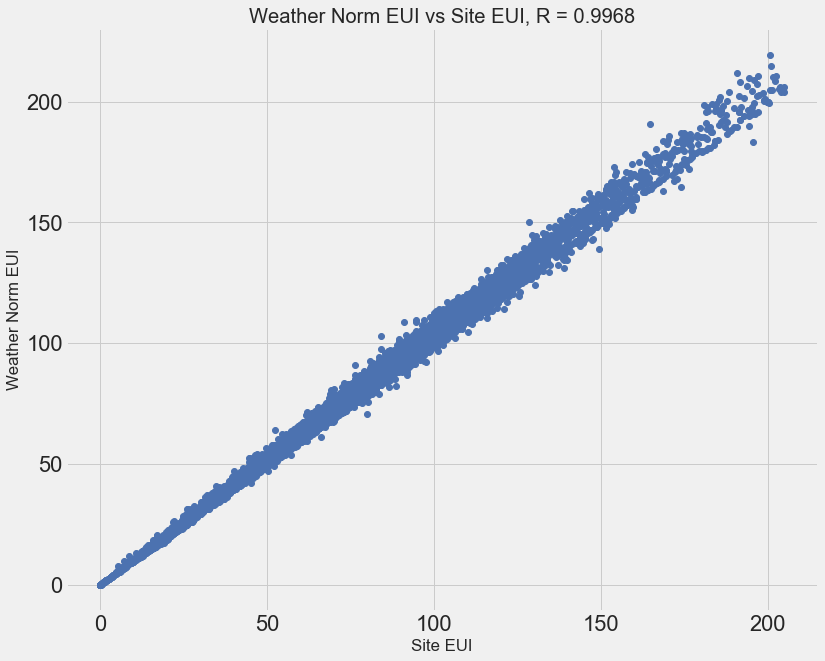

In [29]:
plot_data = data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna()

plt.plot(plot_data['Site EUI (kBtu/ft²)'], plot_data['Weather Normalized Site EUI (kBtu/ft²)'], 'bo')
plt.xlabel('Site EUI'); plt.ylabel('Weather Norm EUI')
plt.title('Weather Norm EUI vs Site EUI, R = %0.4f' % np.corrcoef(data[['Weather Normalized Site EUI (kBtu/ft²)', 'Site EUI (kBtu/ft²)']].dropna(), rowvar=False)[0][1]);

There are a number of methods for removing collinear features, such as using the [Variance Inflation Factor](http://www.statisticshowto.com/variance-inflation-factor/). We will use a simpler metric, and remove features that have a correlation coefficient above a certain threshold with each other (not with the score because we want variables that are highly correlated with the score!) For a more thorough discussion of removing collinear variables, check out [this notebook on Kaggle](https://www.kaggle.com/robertoruiz/dealing-with-multicollinearity/code).

虽然数据集中的变量通常与较小程度相关，但高度共线变量可能是多余的，因为我们只需保留其中一个特征即可为模型提供必要的信息。

删除共线特征是一种通过减少特征数量来降低模型复杂性的方法，
- 可以帮助增加模型泛化
- 还可以帮助我们解释模型

因为我们只需要担心单个变量，例如EUI，而不是EUI和weather normalized EUI如何影响分数。

有许多方法可以消除共线特征，例如使用方差扩大因子。 我们将使用更简单的度量，并删除相关系数高于某个阈值的特征（不是分数，因为我们需要与分数高度相关的变量！）有关删除共线变量的更全面的讨论， 在Kaggle看看这个笔记本。

The following code removes the collinear features based on a threshold we select for the correlation coefficients by removing one of the two features that are compared. It also prints the correlations that it removes so we can see the effect of adjusting the threshold. We will use a threshold of 0.6 which removes one of a pair of features if the correlation coefficient between the features exceeds this value. 

Again, I did not actually write this code from scratch, but rather adapted it from a [Stack Overflow answer](https://stackoverflow.com/a/43104383)

以下代码通过删除所比较的两个特征之一，根据我们为相关系数选择的阈值来移除共线特征。 它还打印它删除的相关性，以便我们可以看到调整阈值的效果。 我们将使用0.6的阈值，如果特征之间的相关系数超过该值，则删除一对特征中的一个。

In [30]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Energy Star Score
    y = x['score']
    x = x.drop(columns = ['score'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    x = x.drop(columns = ['Weather Normalized Site EUI (kBtu/ft²)', 
                          'Water Use (All Water Sources) (kgal)',
                          'log_Water Use (All Water Sources) (kgal)',
                          'Largest Property Use Type - Gross Floor Area (ft²)'])
    
    # Add the score back in to the data
    x['score'] = y
               
    return x

In [31]:
# Remove the collinear features above a specified correlation coefficient
features = remove_collinear_features(features, 0.6);

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater_equal


In [32]:
# Remove any columns with all na values
features  = features.dropna(axis=1, how = 'all')
features.shape

(11319, 65)

我们的最终数据集现在有64个特征（其中一列是目标）。 这仍然是相当多的，但主要是因为我们有一个one-hot编码的分类变量。 此外，虽然诸如线性回归之类的模型可能存在大量特征，但诸如随机森林之类的模型执行隐式特征选择并自动确定在训练期间哪些特征是重要的。 还有其他特征选择步骤，但是现在我们将保留我们拥有的所有特征并查看模型的执行方式。

#### Additional Feature Selection

There are plenty of more methods for [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html). Some popular methods include [principal components analysis (PCA)](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) which transforms the features into a reduced number of dimensions that preserve the greatest variance, or [independent components analysis (ICA)](http://cs229.stanford.edu/notes/cs229-notes11.pdf) which aims to find the independent sources in a set of features. However, while these methods are effective at reducing the number of features, they create new features that have no physical meaning and hence make interpreting a model nearly impossible. 

These methods are very helpful for dealing with high-dimensional data and I would suggest [reading more on the topic](https://machinelearningmastery.com/feature-selection-machine-learning-python/) if you plan on dealing with machine learning problems! 

有更多的特征选择方法。 一些流行的方法包括主成分分析（PCA），它将特征转换为保持最大方差的减少数量的维度，或独立成分分析（ICA），旨在找到一组特征中的独立源。 然而，虽然这些方法在减少特征数量方面是有效的，但它们创造了没有物理意义的新特征，因此几乎不可能解释模型。

这些方法对于处理高维数据非常有用，如果您打算处理机器学习问题，我建议您阅读更多有关该主题的内容！

## 3.2. Split Into Training and Testing Sets- 划分训练集和测试集

本项目中训练集：测试集=7：3，这是训练数据不是那么多的时候的一种选择，如果数据是百万级的甚至更高，这个比例还可以再调整

使用scikit-learn将数据拆分为随机训练和测试集很简单。 我们可以设置拆分的随机状态以确保一致的结果。

In [34]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['score'].isna()]
score = features[features['score'].notnull()]

print(no_score.shape)
print(score.shape)

(1858, 65)
(9461, 65)


In [35]:
# Separate out the features and targets
features = score.drop(columns='score')
targets = pd.DataFrame(score['score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(6622, 64)
(2839, 64)
(6622, 1)
(2839, 1)


We have 1858 buildings with no score, 6622 buildings with a score in the training set, and 2839 buildings with a score in the testing set. We have one final step to take in this notebook: determining a naive baseline for our models to beat! 

# 3.3 Establish a Baseline -  建立Baseline 

在我们开始制作机器学习模型之前建立一个基线是很重要的。 如果我们构建的模型不能胜过基线，那么我们可能不得不承认机器学习不适合这个问题。 这可能是因为我们没有使用正确的模型，因为我们需要更多的数据，或者因为有一个更简单的解决方案不需要机器学习。 建立基线至关重要，因此我们最终可能不会构建机器学习模型，只是意识到我们无法真正解决问题。

对于回归任务，一个好的基线是预测测试集上所有示例的训练集上目标的中值。 这很容易实现，并为我们的模型设置了相对较低的标准：如果它们不能比猜测medin值更好，那么我们需要重新考虑我们的方法。


## Metric: Mean Absolute Error

There are a number of metrics used in machine learning tasks and it can be [difficult to know which one to choose](https://www.analyticsvidhya.com/blog/2016/02/7-important-model-evaluation-error-metrics/). Most of the time it will depend on the particular problem and if you have a specific goal to optimize for. I like [Andrew Ng's advice to use a single real-value performance metric](https://www.coursera.org/learn/machine-learning-projects/lecture/wIKkC/single-number-evaluation-metric) in order to compare models because it simplifies the evaluate process. Rather than calculating multiple metrics and trying to determine how important each one is, we should use a single number. In this case, because we doing regression, the [__mean absolute error__](https://people.duke.edu/~rnau/compare.htm) is an appropriate metric. This is also interpretable because it represents the average amount our estimate if off by in the same units as the target value. 

The function below calculates the mean absolute error between true values and predictions.

我们将使用的度量标准是平均绝对误差（Mean Absolute Error）（MAE），它测量预测的平均绝对误差。有很多回归的指标，但我喜欢Andrew Ng的建议【7】，选择一个指标，然后在评估模型时坚持使用它。平均绝对误差很容易计算，并且可以解释。

In [36]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

Now we can make the median guess and evaluate it on the test set.

In [37]:
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 66.00
Baseline Performance on the test set: MAE = 24.5164


这表明我们对测试集的平均估计偏差约25点。 分数在1到100之间，因此这意味着如果大约25％，则来自朴素方法的平均误差。 猜测训练中值的朴素方法为我们的模型提供了一个低基线！

# Conclusions

1. 清理并格式化原始数据

2. 进行探索性数据分析以了解数据集

3. 开发了一系列我们将用于模型的特征

最后，我们还完成了建立我们可以判断我们的机器学习算法的Baseline的关键步骤。

希望您开始了解管道的每个部分如何流入下一个管道：
**清理数据**并将其转换为正确的格式允许我们执行**探索性数据分析**。 然后，EDA在**特征工程和选择**阶段影响我们的决策。 

这三个步骤通常按此顺序执行，但我们可能会稍后再回来，根据我们的建模结果进行更多的EDA或特征工程。 数据科学是一个迭代过程，我们一直在寻找改进以前工作的方法。 这意味着我们不必在第一时间完成任务（尽管我们可以尽力而为），因为一旦我们对问题有了更多的了解，几乎总有机会重新审视我们的决策。


In part two, we will focus on implementing several machine learning methods, selecting the best model, and optimizing it for our problem using hyperparameter tuning with cross validation. As a final step here, we will save the datasets we developed to use again in the next part. 

In [38]:
# Save the no scores, training, and testing data
no_score.to_csv('data/no_score.csv', index = False)
X.to_csv('data/training_features.csv', index = False)
X_test.to_csv('data/testing_features.csv', index = False)
y.to_csv('data/training_labels.csv', index = False)
y_test.to_csv('data/testing_labels.csv', index = False)